In [1]:
#

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# Open and read CTH data
ds = nc.Dataset("cth_latest.nc")
cth = ds.variables["CTH"][0, :, :]
lat = ds.variables["lat"][:]
lon = ds.variables["lon"][:]
ds.close()

# Mask invalid values (CTH ≤ 0)
cth_masked = np.ma.masked_where(cth <= 0, cth)

# Flatten valid data for clustering
flat_cth = cth_masked.compressed().reshape(-1, 1)

print("✅ CTH shape:", cth.shape, "| Flattened valid pixels:", flat_cth.shape)

✅ CTH shape: (934, 1601) | Flattened valid pixels: (739464, 1)


In [2]:
from sklearn.cluster import KMeans

# Normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cth_scaled = scaler.fit_transform(flat_cth)

# Cluster into 4 groups
kmeans = KMeans(n_clusters=4, n_init='auto', random_state=42)
labels = kmeans.fit_predict(cth_scaled)

# Prepare full label image (with masked regions)
label_image = np.full(cth.shape, fill_value=-1, dtype=int)
label_image[~cth_masked.mask] = labels

print("✅ Clustering done. Cluster centers (standardized):", kmeans.cluster_centers_.ravel())

✅ Clustering done. Cluster centers (standardized): [-0.3591357   1.78877381 -1.15382346  0.61702778]


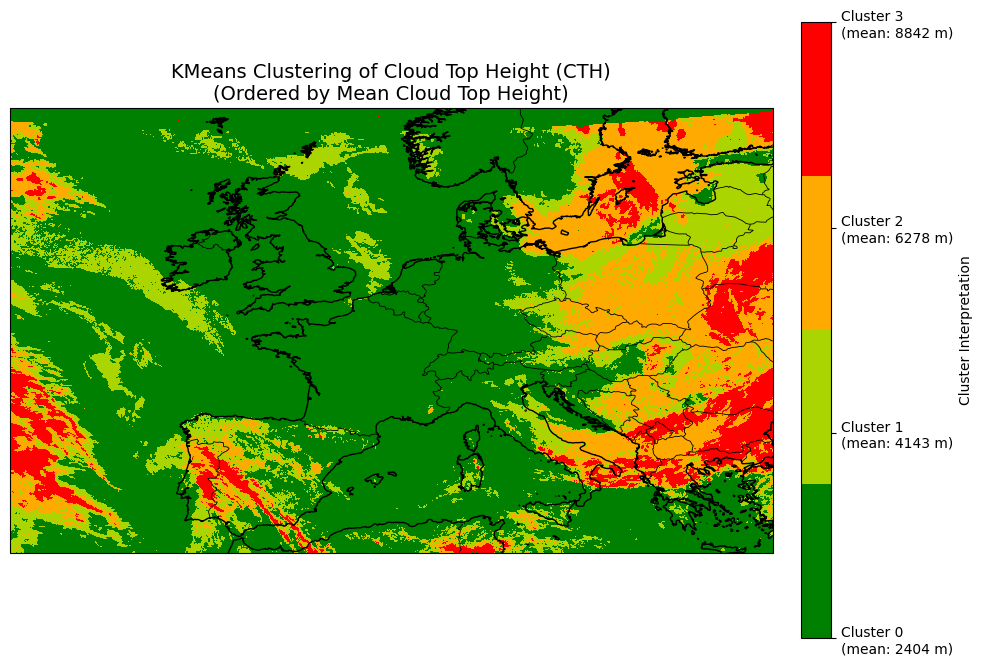

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

# Number of clusters
n_clusters = kmeans.n_clusters

# Step 1: Get original CTH values for each label
original_cth = cth_masked.compressed()
mean_cth = [original_cth[labels == i].mean() for i in range(n_clusters)]

# Step 2: Sort cluster indices by mean CTH
sorted_indices = np.argsort(mean_cth)
remap_dict = {old: new for new, old in enumerate(sorted_indices)}

# Step 3: Remap all labels
remapped_labels = np.array([remap_dict[label] for label in labels])
label_image_ordered = np.full_like(label_image, fill_value=-1)
label_image_ordered[~cth_masked.mask] = remapped_labels

# Step 4: Define semantic labels
cluster_labels = [f"Cluster {i}\n(mean: {mean_cth[sorted_indices[i]]:.0f} m)" for i in range(n_clusters)]

# Step 5: Colormap
from matplotlib.colors import LinearSegmentedColormap

# Define a custom green → yellow → red colormap
alert_colors = ["green", "yellow", "red"]
cmap = LinearSegmentedColormap.from_list("alert_cmap", alert_colors, N=n_clusters)

# Plotting
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Meshgrid
lon2d, lat2d = np.meshgrid(lon, lat)

# Plot
cluster_plot = ax.pcolormesh(
    lon2d, lat2d, label_image_ordered, cmap=cmap, shading="auto", vmin=0, vmax=n_clusters - 1
)

# Map features
ax.coastlines(resolution="10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.set_title("KMeans Clustering of Cloud Top Height (CTH)\n(Ordered by Mean Cloud Top Height)", fontsize=14)

# Colorbar
cbar = plt.colorbar(cluster_plot, orientation='vertical', pad=0.03, ticks=np.arange(n_clusters))
cbar.set_label("Cluster Interpretation")

# Use semantic labels
cbar.ax.set_yticklabels(cluster_labels)

# Save and show
plt.savefig("cth_clusters_ordered.png", dpi=150)
plt.show()


In [8]:
# Get original (unmasked) CTH values by cluster
original_cth_values = cth_masked.compressed()
for i in range(kmeans.n_clusters):
    mean_cth = original_cth_values[labels == i].mean()
    print(f"Cluster {i}: Mean CTH ≈ {mean_cth:.1f} m")


Cluster 0: Mean CTH ≈ 4142.6 m
Cluster 1: Mean CTH ≈ 8841.9 m
Cluster 2: Mean CTH ≈ 2403.9 m
Cluster 3: Mean CTH ≈ 6278.3 m


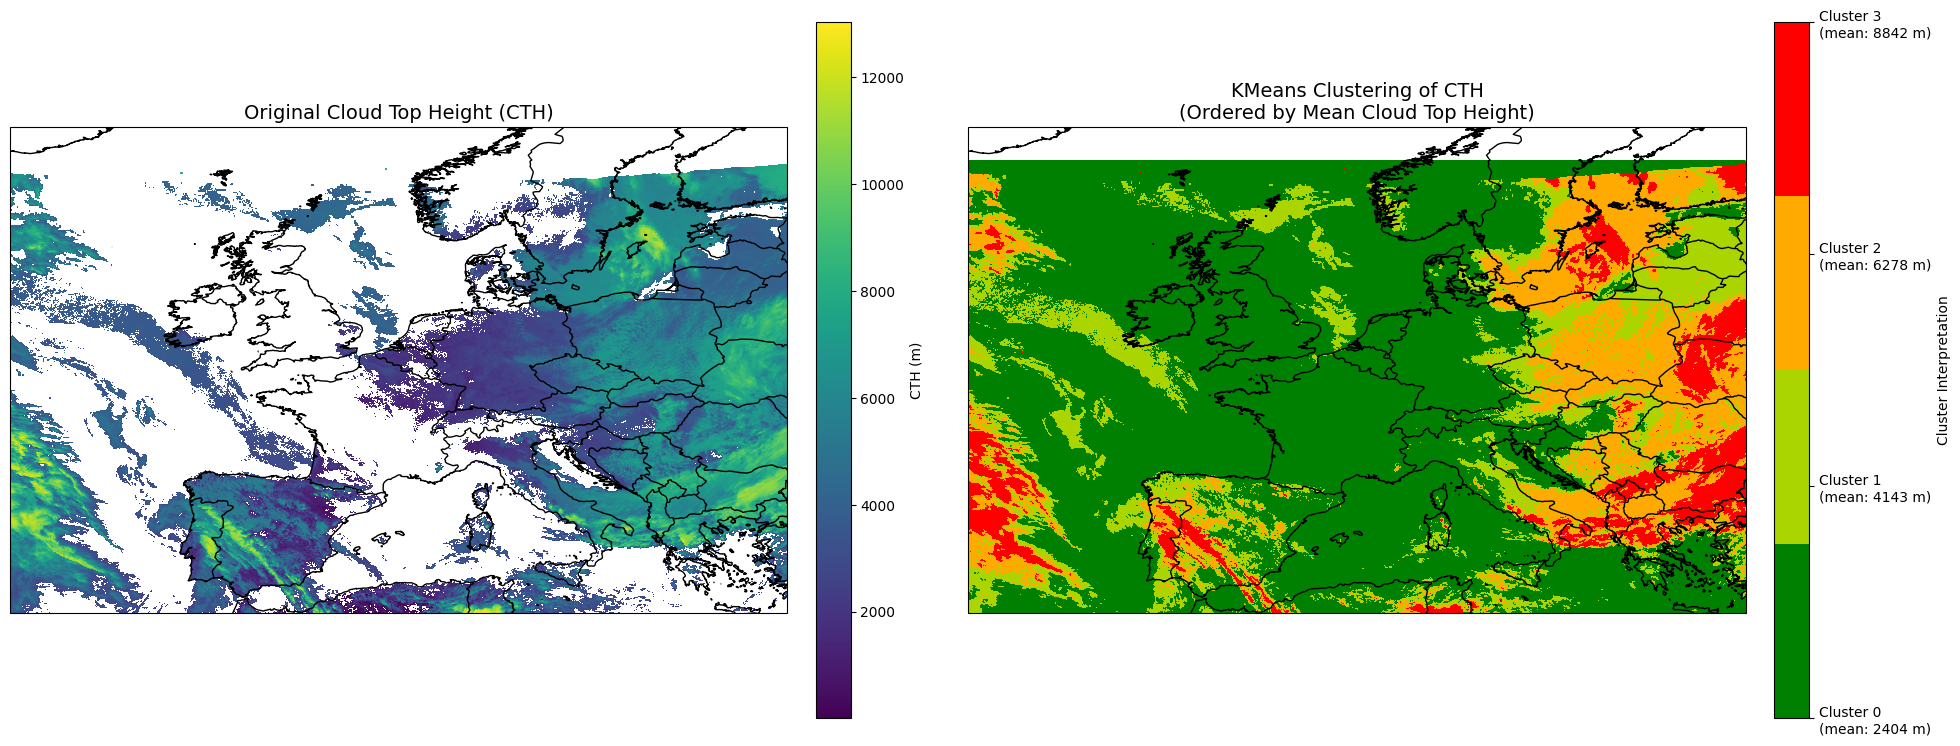

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create colormap for clusters
alert_colors = ["green", "yellow", "red"]
cmap_cluster = LinearSegmentedColormap.from_list("alert_cmap", alert_colors, N=n_clusters)

# Flatten the data for cluster-wise averaging
flat_labels = label_image_ordered.flatten()
flat_cth = cth_masked.flatten()

# Mask out NaNs or invalid data
valid_mask = ~np.isnan(flat_cth)
flat_labels = flat_labels[valid_mask]
flat_cth = flat_cth[valid_mask]

# Step 0: Compute mean CTH for each cluster
mean_cth = np.array([
    flat_cth[flat_labels == i].mean()
    for i in range(n_clusters)
])

# Sort clusters by mean height
sorted_indices = np.argsort(mean_cth)


# Step 2: Cluster labels for colorbar
cluster_labels = [
    f"Cluster {i}\n(mean: {mean_cth[sorted_indices[i]]:.0f} m)"
    for i in range(n_clusters)
]

# Step 3: Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 9), subplot_kw={"projection": ccrs.PlateCarree()})
lon2d, lat2d = np.meshgrid(lon, lat)

# ----- Left: Original CTH map -----
ax = axes[0]
cth_plot = ax.pcolormesh(lon2d, lat2d, cth_masked, cmap="viridis", shading="auto")
ax.set_title("Original Cloud Top Height (CTH)", fontsize=14)
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS)
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
cb1 = plt.colorbar(cth_plot, ax=ax, orientation="vertical", pad=0.03, shrink=0.8)
cb1.set_label("CTH (m)")

# ----- Right: Clustered CTH -----
ax = axes[1]
cluster_plot = ax.pcolormesh(
    lon2d, lat2d, label_image_ordered,
    cmap=cmap_cluster, shading="auto",
    vmin=0, vmax=n_clusters - 1
)
ax.set_title("KMeans Clustering of CTH\n(Ordered by Mean Cloud Top Height)", fontsize=14)
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS)
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
cb2 = plt.colorbar(cluster_plot, ax=ax, orientation="vertical", pad=0.03, shrink=0.8, ticks=np.arange(n_clusters))
cb2.set_label("Cluster Interpretation")
cb2.ax.set_yticklabels(cluster_labels)

# Final layout
plt.tight_layout()
plt.savefig("cth_comparison_side_by_side.png", dpi=150)
plt.show()
